<a href="https://colab.research.google.com/github/SaketMunda/food-vision-101/blob/master/food_vision101_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision App using Tensorflow

A Food Vision app which can tell from detecting the image that what kind of dish it is. The model will be trained by using all of the data from Food101 dataset.

Which has, 75,750 training images and 25,250 testing images of 101 classes (food item).

> **💡 Idea :** Using the food vision app model when user uploads an image, it can detect the image and then tell the amount of calories or micros on that dish based on the image detected. 

### Goal 

We'got the goal of beating [DeepFood](https://arxiv.org/abs/1606.05675), a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

## Check GPUs

Since we're going to use mixed precision training which helps the model to train faster (was introduced in [TensorFLow 2.4.0](https://blog.tensorflow.org/2020/12/whats-new-in-tensorflow-24.html)).

How it does ? In short it uses a combination of single precision (float32) and half precision (float16) datatypes to speed up model training (up 3x on modern GPUs).

But for mixed precision training to work, we need access to a GPU with a compatibility score of 7.0+

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5e678d7f-fe25-01a0-96c3-1ceb6cf2c6f0)


In [ ]:
!nvidia-smi

Mon Jan 23 04:02:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

And Tesla T4 has the compatibility score more than 7.0. **Thanks to Google colab for providing this GPU**. 

In [3]:
# Downgrading the tensorflow version
!pip install tensorflow==2.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 114.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Also check the version of Tensorflow


In [2]:
print(tf.__version__)

2.8.0


## Get Helper Functions

Import some of the helper functions that we created in `helper_functions.py` for unzipping data, walking through directories and few other stuffs.

In [8]:
# Get helper_functions.py script from Github
!wget https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, unzip_data, walk_through_dir, plot_loss_curves    

--2023-01-29 03:57:11--  https://raw.githubusercontent.com/SaketMunda/ml-helpers/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   2.84K  --.-KB/s    in 0s      

2023-01-29 03:57:11 (55.5 MB/s) - ‘helper_functions.py’ saved [2904/2904]



## Use TensorFlow Datasets To Download Data

For many of the popular datasets in the machine learning world (often referred to and used as benchmarks), we can access them through [TensorFLow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview)

In [5]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
# List available datasets
datasets_list = tfds.list_builders() # get all the available datasets
print("food101" in datasets_list)

True


It looks like the dataset we're after is available (note there are plenty more availabel but we're on Food101)

To get acchess to the Food101 dataset from TFDS, we can use the `tfds.load()` method.

In [6]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name='food101', # target dataset to get from TFDS
                                             split=['train', 'validation'], # What splits of data should we get ?
                                             shuffle_files=False, # shuffle files on download to False?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g (image, label)
                                             with_info=True) # include dataset metadata ? if so, returns tuple(data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5TEGK1/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete5TEGK1/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


Now let's get a little information from our dataset, starting with the class names.

Getting class names from a TensorFlow Datasets dataset requires downloading the `dataset_infor` variable (by using the `as_supervised=True` parameter) in the `tfds.load()` method.

In [ ]:
# Features of food101 tfds
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the classnames
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 dataset from TensorFlow Datasets

Let's find out a few details about our dataset,
- The shape of our input data (image tensors)
- The datatype of our input data
- What the labels of our input data look like (e.g one-hot encoded versus label-encoded)
- Do the labels match up with the class names ?

In [ ]:
# Take one sample of the training dat
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

So it says, one sample is in the format of tuples (image_tensor, label)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image dtype : {image.dtype}
  Target Class(tensor form) : {label}
  Class name (str form): {class_names[label.numpy()]}
  """
  )


  Image Shape : (512, 512, 3)
  Image dtype : <dtype: 'uint8'>
  Target Class(tensor form) : 90
  Class name (str form): spaghetti_bolognese
  


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result everytime.

Checking these we can know that the shape of images have different shapes for example, (512, 512, 3) but all have the 3 color channels followed by height, width

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [ ]:
# What does an image tensor from TFDS look like
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

I guess, the range of values of the above must be 0-255 as we all know that images have pixel values of (0,255)

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

There we go !

Now let's visualize by plotting one of the image with the label name to make things clear

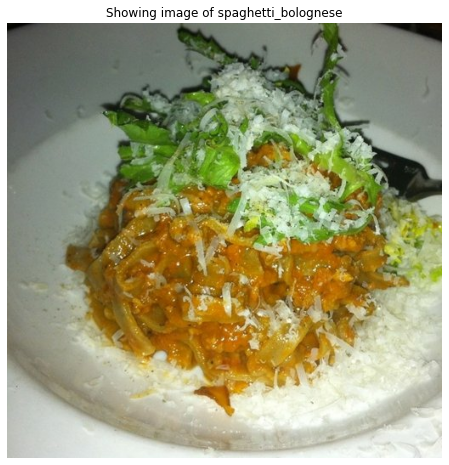

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title(f'Showing image of {class_names[label.numpy()]}')
plt.imshow(image)
plt.axis(False);

Healthy ! Looks like the Food101 data we've got from TFDS is similar to the datasets we've been using in previous notebooks.

Now let's preprocess it and get it ready for use with a neural network.

## Create preprocessing functions of our data

There are a couple of of preprocessing steps we have to take before it's ready to model,

More specifically, our data is currently:
- In `uint8` datatype
- Comprised of all different size tensors(different sized image)
- Not scaled (the pixel values are between 0 & 255)

Whereas, models like the data to be:
- In `float32` datatype
- Have all of the same size tensors (batches require all tensors have the same shape, e.g `(224, 224, 3)`)
- Scaled (values between 0 & 1), also called normalized

For B0 to B7 base models, the input shapes are different. Here is a list of input shape
expected for each model:

| Base model | resolution|
|----------------|-----|
| EfficientNetB0 | 224 |
| EfficientNetB1 | 240 |
| EfficientNetB2 | 260 |
| EfficientNetB3 | 300 |
| EfficientNetB4 | 380 |
| EfficientNetB5 | 456 |
| EfficientNetB6 | 528 |
| EfficientNetB7 | 600 |

In [9]:
# Make a function for preprocessing images

img_shape = 224 # for EfficientNetB0

def preprocess_img(image, label, img_shape=img_shape, scale=False):
  """
  Converts image datatype from `uint8` to `float32` and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape

  if scale:
    image = image/255.
  
  return tf.cast(image, tf.float32), label

Let's try our function out on a target image

In [ ]:
preprocess__one_img = preprocess_img(image=image, 
                                     label=label)

In [ ]:
preprocess__one_img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.1586735e+01, 1.2586735e+01, 6.5867348e+00],
        [1.1714286e+01, 1.2714286e+01, 6.7142859e+00],
        [8.8571424e+00, 9.8571424e+00, 4.8571424e+00],
        ...,
        [2.0714308e+01, 1.1142836e+01, 1.2857144e+00],
        [2.0668371e+01, 1.0668372e+01, 0.0000000e+00],
        [2.1000000e+01, 1.1000000e+01, 0.0000000e+00]],

       [[2.3571415e+00, 3.3571415e+00, 1.4285660e-01],
        [3.1530607e+00, 4.1530609e+00, 7.6530278e-02],
        [3.0561223e+00, 4.0561223e+00, 0.0000000e+00],
        ...,
        [2.6071407e+01, 1.8071407e+01, 7.0714073e+00],
        [2.4785702e+01, 1.4785702e+01, 4.7857018e+00],
        [2.2499966e+01, 1.2499966e+01, 2.4999657e+00]],

       [[1.3520410e+00, 2.3520410e+00, 0.0000000e+00],
        [3.0408173e+00, 4.0408173e+00, 6.1224538e-01],
        [7.2346954e+00, 8.1887770e+00, 3.3265321e+00],
        ...,
        [2.5479622e+01, 1.7382635e+01, 8.3826580e+00],
        [2.6056133e+01

It looks like it casted it into float32 and also changed the shape to (224, 224, 3)

## Batch and prepare datasets

Before we can model our data, we have to turn it into batches.

Because computing on batches is memory efficient.

We turn our data from 101,000 images tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from `tf.data` API.

Specifically, we're going to be using:

- `map()` - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
- `shuffle()` - randomly shuffles the element of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
- `batch()` - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
- `prefetch()` - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but **costs memory**)
- Extra: `cache()` - caches (save them for later) elements in a target dataset, saving loading time 


In [10]:
# let's process the images first
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train_data and turn it into bacthes and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# turn it into batches and prefetch it
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Looks like our data is converted into PrefetchDataset and also in the batches, hence the shape is (None, 224, 224, 3) for EfficientNetB0 and for EfficientNetB7 the shape is (NOne, 600, 600,3) as it rescales as well and casted into `float32`

## Create modelling callbacks

We have created `Tensorboard` callbacks in our helper functions, and also imported at the beginning of this notebook, so only need to create other callback functions. 

### Model Checkpoints

`ModelCheckpoint` callback to save the model checkpoints as it's very helpful so that when we fine-tune our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits.

In [12]:
# Create modelcheckpoint callback to save model's progress
feature_extraction_checkpoint_path = 'model_checkpoints/cp.cpkt' # saving weights requires ".ckpt" extension
feature_extraction_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(feature_extraction_checkpoint_path,
                                                      monitor='val_accuracy', 
                                                      save_best_only=True,                                                     
                                                      save_weights_only=True,
                                                      mode='max',
                                                      verbose=0)

fine_tune_checkpoint_path = 'fine_tune_checkpoints/'
fine_tune_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(fine_tune_checkpoint_path,
                                                       monitor='val_loss',
                                                       save_best_only = True)

### Early Stopping

During fine-tuning, we might need to create some more callbacks to save the model's progress.

**Early Stopping**: Used to Stop training when a monitored metric has stopped improving


In [13]:
# Setup earlystopping callback to stop training if model's loss doesn't improve for 2 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', # or val_loss
                                                  patience=2,
                                                  verbose=1,
                                                  restore_best_weights=True)

### ReducingLROnPlateau 

It helps to tune the learning rate for us.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback monitors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

As the training goes on and our model gets closer and closer to ideal's performance (also called **convergence**), we want to the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [14]:
# creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', # or val_loss
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2, # this is equal to the number of epochs approx
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

## Setup Mixed Precision

Normally tensors in TensorFlow default to float32 datatypes (float32 is also known as single-precision floating-point format).

The 32 means it usually occupies 32 bits in computer memory.

Our GPU has a limited memory, therefore it can handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves mixing of float32 and float16(half-precision floating-point format) tensors to make better use of our GPU's memory.

When using mixed precision training, our model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

Guide: https://www.tensorflow.org/guide/mixed_precision

In [15]:
# Turn on Mixed precision
from tensorflow.keras import mixed_precision

# set the float16 mixed precision
mixed_precision.set_global_policy('mixed_float16')

View what mixed precision is set,


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
policy = mixed_precision.Policy('mixed_float16')

print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')

Compute dtype: float16
Variable dtype: float32


Since we are now enabled `mixed_precision` for mixed precision training, our model needs a separate output layer with a hard-coded `dtype=tf.float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to our float32 datatype which is more numerically stable than the float16 datatype (important for loss calculations)

## Build & Fit Feature Extraction Model

We will be experimenting with various models available in tensorflow through `tf.keras.applications`, so we should create a function first so that we can re-use the same process and continue experimenting.

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

def build_feature_extraction_model(base_model, 
                                   input_shape=(224, 224, 3), 
                                   train_data=train_data, 
                                   test_data=test_data, 
                                   model_callbacks=[],                                  
                                   use_dropout_layers=False,
                                   epochs=5,
                                   learning_rate=0.001):
  """
  This function will help to build feature extraction model based on the 
  base_model passed as parameter, it'll return the compiled and fitted model
  with training and test set of data

  Also responsible for logging the weights of model through ModelCheckpoint 
  so that it can grabbed when needed and other callbacks as well as per the 
  use of the model 

  **Params**:
    - base_model : Models available in tensorflow (tf.keras.applications)
    - input_shape : Shape of input layer
    - train_data : training data
    - test_data : testing data
    - model_callbacks(list) : list of callbacks to be used while fitting the model
    - use_dropout_layers(bool) : default False, if True then Dropout layers will be used
    - epochs : number of epochs while fitting
    - feature_extraction_fine_tune_together(bool): Fine Tune and Feature Extract in the same step
  
  **Return**:
    - History and fitted model
  """
  # Create base model      
  base_model.trainable=False # freeze base model layers

  # Create functional model
  inputs = layers.Input(shape=input_shape, name='input_layer')  
  x = base_model(inputs) # to set base_model to inference mode only use as base_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)

  if use_dropout_layers:
    top_dropout_rate = 0.3
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # use dropout layers to prevent overfitting
  
  x = layers.Dense(len(class_names))(x)
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", name='activation_layer', dtype=tf.float32)(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile the model
  model.compile(loss='sparse_categorical_crossentropy', # Using sparse_categorical_crossentropy when lables are not one-hot encoded
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                metrics=['accuracy'])
  # fit the model
  history = model.fit(train_data,
                      epochs=epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=model_callbacks)
  
  return history, model

### EfficientNetB0 Model

Experiment using EfficientNetB0 Feature Extracted Model

In [ ]:
# efficientnetb0_feature_history, efficientnetb0_feature_model = build_feature_extraction_model(base_model=tf.keras.applications.EfficientNetB0(include_top=False),
#                                                                                               experiment_name='feature_extraction_efficientnetb0')
# Need provide more params in the function

Saving Tensorboard log files to: training_logs/feature_extraction_efficientnetb0/20230123-043556


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - 189s 73ms/step - loss: 1.8242 - accuracy: 0.5566 - val_loss: 1.2315 - val_accuracy: 0.6793
Epoch 2/3
2368/2368 [==============================] - 176s 73ms/step - loss: 1.2956 - accuracy: 0.6653 - val_loss: 1.1270 - val_accuracy: 0.7034
Epoch 3/3
2368/2368 [==============================] - 178s 74ms/step - loss: 1.1452 - accuracy: 0.7019 - val_loss: 1.0975 - val_accuracy: 0.7090


### EfficientNetB4 Model

Experiment using EfficientNetB4 Feature Extracted Model

<!-- As quoted below from [Paper](https://arxiv.org/abs/1905.11946)

"*In particular, our EfficientNet-B7 achieves state-of-the-art 84.3% top-1 accuracy on ImageNet, while being 8.4x smaller and 6.1x faster on inference than the best existing ConvNet. Our EfficientNets also transfer well and achieve state-of-the-art accuracy on CIFAR-100 (91.7%), Flowers (98.8%), and 3 other transfer learning datasets, with an order of magnitude fewer parameters*" -->

In [ ]:
# efficientnetb4_feature_history, efficientnetb4_feature_model = build_feature_extraction_model(base_model=tf.keras.applications.EfficientNetB4(include_top=False),
#                                                                                               experiment_name='feature_extraction_efficientnetb4')
# Need to provide more function

71696384/71686520 [==============================] - 2s 0us/step
Saving Tensorboard log files to: training_logs/feature_extraction_efficientnetb4/20230124-042431


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - 278s 109ms/step - loss: 1.8710 - accuracy: 0.5393 - val_loss: 1.3343 - val_accuracy: 0.6528
Epoch 2/3
2368/2368 [==============================] - 259s 108ms/step - loss: 1.3909 - accuracy: 0.6389 - val_loss: 1.2548 - val_accuracy: 0.6748
Epoch 3/3
2368/2368 [==============================] - 257s 107ms/step - loss: 1.2409 - accuracy: 0.6745 - val_loss: 1.2048 - val_accuracy: 0.6788


### EfficientNetB0 Model (Using Dropout Layers and Other Settings)

In [18]:
efficientnetb0_history_FE, efficientnetb0_model_FE = build_feature_extraction_model(base_model=tf.keras.applications.EfficientNetB0(include_top=False),                                                                                    
                                                                                    model_callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                                                           experiment_name="EfficientNetB0_FE"),
                                                                                                     early_stopping,
                                                                                                     feature_extraction_model_checkpoint],
                                                                                    epochs=15,                                                                                    
                                                                                    use_dropout_layers=True)

16719872/16705208 [==============================] - 0s 0us/step
Saving Tensorboard log files to: training_logs/EfficientNetB0_FE/20230129-040540
Epoch 1/15
2368/2368 [==============================] - 187s 71ms/step - loss: 2.0251 - accuracy: 0.5077 - val_loss: 1.2789 - val_accuracy: 0.6626
Epoch 2/15
2368/2368 [==============================] - 172s 71ms/step - loss: 1.5409 - accuracy: 0.6036 - val_loss: 1.1759 - val_accuracy: 0.6854
Epoch 3/15
2368/2368 [==============================] - 172s 71ms/step - loss: 1.4425 - accuracy: 0.6253 - val_loss: 1.1313 - val_accuracy: 0.6936
Epoch 4/15
2368/2368 [==============================] - 171s 71ms/step - loss: 1.3918 - accuracy: 0.6376 - val_loss: 1.1071 - val_accuracy: 0.6997
Epoch 5/15
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3600 - accuracy: 0.6450 - val_loss: 1.0941 - val_accuracy: 0.7026
Epoch 6/15
2368/2368 [==============================] - 163s 68ms/step - loss: 1.3360 - accuracy: 0.6489 - val_loss: 1.

## Checking layer dtype policies (are we using mixed precision ?)
Let's check the datatypes of each layers in `efficientnetb0_model_FE`

In [ ]:
# check efficientnetbo feature extraction model layers
for layer in efficientnetb0_model_FE.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb7 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


We can see that except input and output layer all have float16 dtype_policy, this is because we enabled mixed precision training.

let's check the base_model's layers,

In [ ]:
for layer in efficientnetb0_model_FE.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Policy "mixed_float16">
block1b_bn False float32 <Policy

Here also all the layers have dtype_policy as float16. Alright !

Let's move into training our model, means fit our model with train data and then evaluate it with test data.

## Evaluate the feature extraction model

Evaluate the feature extraction models in whole `test_data`.


In [ ]:
def evaluate_feature_models(model, test_data=test_data):
  results = model.evaluate(test_data)
  return results

### EfficientNetB0 Model

In [ ]:
results_efficientnetb0_feature = evaluate_feature_models(model=efficientnetb0_feature_model)
results_efficientnetb0_feature

790/790 [==============================] - 51s 64ms/step - loss: 1.0966 - accuracy: 0.7038


[1.0965533256530762, 0.7038415670394897]

**Feature Extraction EfficientNetB0 results is touching almost 70% of accuracy on whole test set.**

In [ ]:
# checking the model's summary
efficientnetb0_feature_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                          

### EfficientNetB4 Model

In [ ]:
results_efficientnetb4_feature = evaluate_feature_models(model=efficientnetb4_feature_model)
results_efficientnetb4_feature

790/790 [==============================] - 78s 98ms/step - loss: 1.2024 - accuracy: 0.6777


[1.202353835105896, 0.6777029633522034]

In [ ]:
# checking the model's summary
efficientnetb4_feature_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 pooling_layer (GlobalAverag  (None, 1792)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-traina

In [ ]:
# difference in the number of params of B4 and B0
17673823/4049571

15x more params than EfficientNetB0 model

### EfficientNetB7 Model

In [ ]:
efficientnetb7_model_FE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 pooling_layer (GlobalAverag  (None, 2560)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               258661    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 64,356,348
Trainable params: 258,661
Non-traina

In [ ]:
64097687/17673823

3.626701874291714

## Load and evaluate checkpoint weights (Optional)

We can load in and evaluate our model's checkpoints by:

1. Cloning our model using `tf.keras.models.clone_model()` to make a copy of our feature extraction model with reset weights
2. Calling the `load_weights()` method on our clones model passing it the path to where our checkpointed weights are stored.
3. Calling `evaluate()` on the cloned model with loaded weights.

**Doing this experiment for only EfficientNetB0 Feature Extracted Model**

In [ ]:
cloned_model = tf.keras.models.clone_model(model=efficientnetb0_feature_model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation_layer (Activatio  (None, 101)              0         
 n)                                                              
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

The structure of `cloned_model` and a trained `model` looks same and it's parameter.

In [ ]:
# load the weights from the checkpoint path
checkpoint_path

'model_checkpoints/cp.cpkt'

In [ ]:
cloned_model.load_weights(checkpoint_path)

Each time we make changes to our model or load weights from the checkpoint path, we have to recompile the model

In [ ]:
cloned_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer='Adam',                     
                     metrics=['accuracy'])

In [ ]:
# evaluate the model
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

790/790 [==============================] - 55s 67ms/step - loss: 1.7181 - accuracy: 0.5501


[1.7181307077407837, 0.5500593781471252]

These results should be very close to the feature extraction model's results but it isn't let's try by comparing with `np.isclose()`

In [ ]:
# Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving,
import numpy as np
np.isclose(results_efficientnetb0_feature, results_cloned_model_with_loaded_weights).all()

False

> **Why** ? 
Because Cloning the model preserves `dtype_policy`'s of layers (**but doesn't preserve weights**) so if we wanted to continue fine-tuning with the cloned model, we could it would still use the mixed precision dtype policy.

## Visualizing and comparing the weights of Models (To do)

In [ ]:
#To Do
# import matplotlib.pyplot as plt

# # def hist_weights(weights, bins=500):
# #   for weight in weights:
# #     plt.hist(weight, bins=bins)

# W = model.layers[1].get_weights() # getting the feature extracted model weights

# for w in W[:5]:
#   print(w)
#   print(w.shape)

#hist_weights(W)

## Save Feature Extraction Model

We can save the whole model using the `save()` method

In [1]:
import os

dir = 'drive/MyDrive/Data Science/FoodVision101/'
#dir = 'drive/MyDrive/MLprojects/FoodVision/'

def save_model(dir, model, model_name):
  path = f'{dir}{model_name}'

  # make dir
  os.makedirs(path)
  # save the model  
  model.save(path)

### EfficientNetB0 Model

In [ ]:
# saving efficientnetb0 feature extraction model
save_model(dir=dir,
           model=efficientnetb0_feature_model,
           model_name='efficientnetb0_feature_extraction')

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Model can be loaded through as SavedModel format: `drive/MyDrive/Data Science/FoodVision101/efficientnetb0_feature_extraction`

And again, we can check whether or not our model saved correctly by loading it in evaluating it

In [ ]:
# loaded_saved_model = tf.keras.models.load_model(save_dir)

### EfficientNetB4 Model

In [ ]:
# saving efficientnetb7 feature extraction model
save_model(dir=dir,
           model=efficientnetb4_feature_model,
           model_name='efficientnetb4_feature_extraction')

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# load the saved feature extraction model
save_dir = 'drive/MyDrive/Data Science/FoodVision101/efficientnetb4_feature_extraction'

loaded_efficientnetb4_saved_model = tf.keras.models.load_model(save_dir)

### EfficientNetB0 Model (Other Settings)


In [2]:
save_model(dir=dir,
           model=efficientnetb0_model_FE,
           model_name='efficientnetb0_fe')

NameError: ignored

## Fine-tuning our Model

Let's fine tuned the above loaded model that we feature extracted and achieved `70%` approx validation accuracy in our full test data set. 

To fine-tune the model, let's make all the layer trainable which means we have to unfreeze all the layers

In [21]:
def unfreeze_layers(model, num_of_layers=None):
  """
  Function to unfreeze all the layers of base_model
  """
  if num_of_layers is None:
    for layer in model.layers:
      layer.trainable=True
  else:    
    for layer in model.layers:
      layer.trainable=True
    

### EfficientNetB0 Model


In [ ]:
unfreeze_layers(efficientnetb0_feature_model)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


In [ ]:
# Checking some layers of `base_model` as well,
for layer in efficientnetb0_feature_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

It seems all the layers inside the `base_model` is trainable and unfrozen, let's keep it that way because we have enough data to train them.

In [ ]:
# compile the model
efficientnetb0_feature_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history_fine_tune_efficientnetb0_model = efficientnetb0_feature_model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", "efficient_netb0_fine_tune"),
                                               model_checkpoint,
                                               early_stopping,
                                               reduce_lr])

Saving Tensorboard log files to: training_logs/efficient_netb0_fine_tune/20230123-045314
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 0.7514

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 398s 161ms/step - loss: 0.9255 - accuracy: 0.7514 - val_loss: 0.8382 - val_accuracy: 0.7627 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5692 - accuracy: 0.8445

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 375s 158ms/step - loss: 0.5692 - accuracy: 0.8445 - val_loss: 0.8175 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 331s 139ms/step - loss: 0.3117 - accuracy: 0.9131 - val_loss: 0.9482 - val_accuracy: 0.7797 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.9529
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 325s 136ms/step - loss: 0.1613 - accuracy: 0.9529 - val_loss: 1.1180 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 325s 137ms/step - loss: 0.0404 - accuracy: 0.9897 - val_loss: 1.0881 - val_accuracy: 0.8022 - lr: 2.0000e-05


### EfficientNetB4 Model

In [ ]:
#unfreeze_layers(efficientnetb4_feature_model)
# unfreeze loaded model
unfreeze_layers(loaded_efficientnetb4_saved_model)

input_layer True float32 <Policy "float32">
efficientnetb4 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
activation_layer True float32 <Policy "float32">


In [ ]:
# compile the model
loaded_efficientnetb4_saved_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history_fine_tune_efficientnetb4_model = loaded_efficientnetb4_saved_model.fit(train_data,
                                    epochs=100,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", "efficientnetb4_fine_tune"),                                               
                                               early_stopping,
                                               reduce_lr])

Saving Tensorboard log files to: training_logs/efficientnetb4_fine_tune/20230125-045042
Epoch 1/100
2368/2368 [==============================] - 741s 302ms/step - loss: 0.1096 - accuracy: 0.9687 - val_loss: 1.0182 - val_accuracy: 0.8093 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9896
Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 715s 301ms/step - loss: 0.0387 - accuracy: 0.9896 - val_loss: 1.2595 - val_accuracy: 0.8051 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 715s 301ms/step - loss: 0.0120 - accuracy: 0.9973 - val_loss: 1.3159 - val_accuracy: 0.8146 - lr: 2.0000e-05
Epoch 4/100
2368/2368 [==============================] - 735s 310ms/step - loss: 0.0024 - accuracy: 0.9998 - val_loss: 1.5295 - val_accuracy: 0.8191 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0011 

KeyboardInterrupt: ignored

**Cancelling this training because model is started over-fitting too much.**

### EfficientNetB0 Model (other settings)

In [ ]:
unfreeze_layers(efficientnetb0_model_FE)  

In [ ]:
efficientnetb0_model_FE.compile(loss='sparse_categorical_crossentropy',
                                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                metrics=['accuracy'])

In [ ]:
history_fine_tune_efficientnetb0_model = efficientnetb0_model_FE.fit(train_data,
                                    epochs=50,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_fine_tune"),                                               
                                               early_stopping,
                                               reduce_lr])

Saving Tensorboard log files to: training_logs/efficientnetb7_fine_tune/20230127-042224


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
2368/2368 [==============================] - 639s 260ms/step - loss: 1.1942 - accuracy: 0.6850 - val_loss: 0.8565 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 2/50
2368/2368 [==============================] - 611s 257ms/step - loss: 0.6097 - accuracy: 0.8308 - val_loss: 0.8680 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.9232
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 629s 264ms/step - loss: 0.2754 - accuracy: 0.9232 - val_loss: 0.9243 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 4/50
2368/2368 [==============================] - 612s 257ms/step - loss: 0.1081 - accuracy: 0.9729 - val_loss: 0.8855 - val_accuracy: 0.7969 - lr: 2.0000e-05
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9848
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.999999898951501

## Save and Load Fine-Tuned Model

We should save the fine-tuned model first and then do the further evaluation.

### EfficientNetB0 Model

In [ ]:
# saving the fine-tine model
model_name = 'efficientnetb0_fine_tuned'

# saving efficientnetb0 fine-tuned model
save_model(dir=dir,
           model=efficientnetb0_feature_model,
           model_name=model_name) 

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# Load the fine-tuned model
loaded_fine_tuned_model = tf.keras.models.load_model(f'{dir}{model_name}')

In [ ]:
# evaluate the model on whole test_data
results_fine_tune = loaded_fine_tuned_model.evaluate(test_data)
results_fine_tune

790/790 [==============================] - 53s 65ms/step - loss: 1.1051 - accuracy: 0.7970


[1.1050703525543213, 0.7969900965690613]

**Great it looks like, we have achieved almost 80% of accuracy on test dataset. Let's do further evaluations.**

### EfficientNetB4 Model

In [ ]:
# saving the fine-tine model
model_name = 'efficientnetb4_fine_tuned'

# saving efficientnetb0 fine-tuned model
save_model(dir=dir,
           model=loaded_efficientnetb4_saved_model,
           model_name=model_name) 

In [ ]:
# Load the fine-tuned model
loaded_fine_tuned_b7_model = tf.keras.models.load_model(f'{dir}{model_name}')

In [ ]:
# evaluate the model on whole test_data
results_fine_tune_b7 = loaded_fine_tuned_b7_model.evaluate(test_data)
results_fine_tune

## Evaluating Fine-Tuned Model with Various Metrics

We should go through various evaluation experiments which will help us to understand the results of our model much better, so let's do some,
1. Find the precision, recall and f1 scores for each class (all 101)
2. Build a confusion matrix for each of the classes
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).

To start with, we have to make predictions,

In [ ]:
# Make the prediction with the test_data
pred_probs = loaded_fine_tuned_model.predict(test_data, verbose=1)

790/790 [==============================] - 66s 67ms/step


Alright we have obtained the prediction probabilities of 790 batches and 790 * 32 = 25250 (approx) images

In [ ]:
len(pred_probs)

25250

Great ! It means we have prediction probabilities of each image and all in the format of tensor array.

In [ ]:
pred_probs.shape

(25250, 101)

By checking the highest probability among that array of tensors would tell us that, for that particular sample what model is predicted,

In [ ]:
# let's check for sample 4
pred_probs[4].argmax(), class_names[pred_probs[4].argmax()]

(60, 'lobster_bisque')

Looks great ! But we're not sure whether the prediction is correct or not, we have to compare it with the truth labels, but first let's convert the prediction probabilities into index for `class_names`.

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

Now we have to obtain the truth labels from our `test_data`, since the `test_data` are in batches, so we have to unbatch it first and then fetch the labels only.

In [ ]:
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy()) # not using argmax() here because labels are not one-hot encoded

y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
# How many labels we have?
len(y_labels)

25250

In [ ]:
# Let's check one of evaluation metrics accuracy_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_labels, pred_classes)

accuracy

0.7948118811881189

This should be equal to `results_fine_tuned_model`

In [ ]:
load_loss, load_accuracy = results_fine_tune

import numpy as np

np.isclose(accuracy, load_accuracy)

True

Now we are ready for evaluations,

start with 

### .1. Find the precision, recall and f1 scores for each class (all 101)

In [ ]:
from sklearn.metrics import classification_report

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

classification_report_dict

{'0': {'precision': 0.64,
  'recall': 0.576,
  'f1-score': 0.6063157894736841,
  'support': 250},
 '1': {'precision': 0.8277511961722488,
  'recall': 0.692,
  'f1-score': 0.7538126361655773,
  'support': 250},
 '2': {'precision': 0.8449612403100775,
  'recall': 0.872,
  'f1-score': 0.858267716535433,
  'support': 250},
 '3': {'precision': 0.8487394957983193,
  'recall': 0.808,
  'f1-score': 0.8278688524590164,
  'support': 250},
 '4': {'precision': 0.7107142857142857,
  'recall': 0.796,
  'f1-score': 0.7509433962264151,
  'support': 250},
 '5': {'precision': 0.7252252252252253,
  'recall': 0.644,
  'f1-score': 0.6822033898305084,
  'support': 250},
 '6': {'precision': 0.8277153558052435,
  'recall': 0.884,
  'f1-score': 0.8549323017408125,
  'support': 250},
 '7': {'precision': 0.8712121212121212,
  'recall': 0.92,
  'f1-score': 0.8949416342412451,
  'support': 250},
 '8': {'precision': 0.5935251798561151,
  'recall': 0.66,
  'f1-score': 0.625,
  'support': 250},
 '9': {'precision': 0.

Let's extract the `precision`, `recall` and `f1-score` from the above dictionary

In [ ]:
f1_score = {}
precision = {}
recall = {}

for k,v in classification_report_dict.items():
  if k == 'accuracy': 
    break
  else:
    key = class_names[int(k)]
    f1_score[key] = v['f1-score']
    precision[key] = v['precision']
    recall[key] = v['recall']

f1_score

{'apple_pie': 0.6063157894736841,
 'baby_back_ribs': 0.7538126361655773,
 'baklava': 0.858267716535433,
 'beef_carpaccio': 0.8278688524590164,
 'beef_tartare': 0.7509433962264151,
 'beet_salad': 0.6822033898305084,
 'beignets': 0.8549323017408125,
 'bibimbap': 0.8949416342412451,
 'bread_pudding': 0.625,
 'breakfast_burrito': 0.7194570135746605,
 'bruschetta': 0.734966592427617,
 'caesar_salad': 0.8365758754863815,
 'cannoli': 0.8435643564356436,
 'caprese_salad': 0.7898832684824902,
 'carrot_cake': 0.7677165354330708,
 'ceviche': 0.6997840172786177,
 'cheesecake': 0.6476868327402137,
 'cheese_plate': 0.8378378378378377,
 'chicken_curry': 0.7006109979633401,
 'chicken_quesadilla': 0.8090349075975358,
 'chicken_wings': 0.8657314629258517,
 'chocolate_cake': 0.7096774193548386,
 'chocolate_mousse': 0.6051502145922747,
 'churros': 0.8594704684317719,
 'clam_chowder': 0.8532818532818534,
 'club_sandwich': 0.8517745302713987,
 'crab_cakes': 0.7,
 'creme_brulee': 0.8665377176015473,
 'croque

Great ! This is what we were looking for.

In [ ]:
import pandas as pd

f1_score_df = pd.DataFrame({'class_names':list(f1_score.keys()),
                            'f1_score':list(f1_score.values())}).sort_values(by='f1_score', ascending=False)
f1_score_df

,class_names,f1_score
33,edamame,0.981891
63,macarons,0.941414
91,spaghetti_carbonara,0.927022
64,miso_soup,0.918367
54,hot_and_sour_soup,0.917836
...,...,...
77,pork_chop,0.615385
0,apple_pie,0.606316
22,chocolate_mousse,0.605150
39,foie_gras,0.587738


How about plotting with horizontal bar chart?

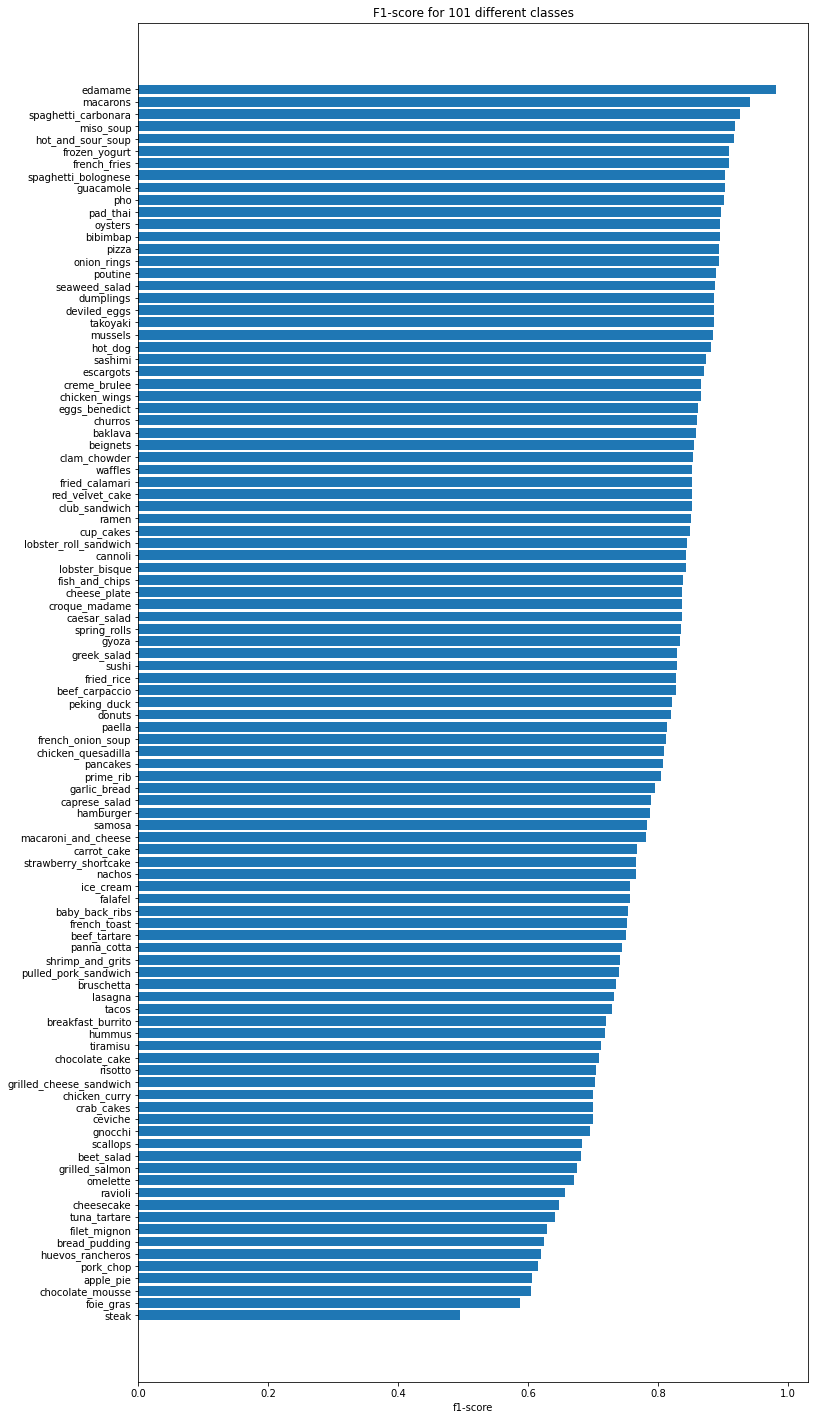

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))

scores = ax.barh(range(len(f1_score_df)), f1_score_df['f1_score'].values)

ax.set(yticks=range(len(f1_score_df)),
       yticklabels=list(f1_score_df['class_names']),
       xlabel='f1-score',
       title='F1-score for 101 different classes')
ax.invert_yaxis();



Like-wise we can plot the horizontal bar chart for `precision` and `recall` but the `f1-score` is the combination of both so we'll be good with only plotting `f1-score`

### .2. Build a Confusion matrix for each of the classes 

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_labels, pred_classes))

[[144   1   9 ...   3   0   7]
 [  0 173   0 ...   0   0   0]
 [ 10   0 218 ...   0   0   0]
 ...
 [  0   0   0 ... 178   0   0]
 [  0   0   0 ...   0 154   1]
 [  6   0   1 ...   0   0 215]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15, norm=False, savefig=False):
  
  # Create confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]
  ticks = np.arange(n_classes)

  # plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Are there a list of classes ?
  if classes:
    labels = classes
  else:
    labels = ticks
  
  # label the axes
  ax.set(title='Confusion Matrix',
         xlabel='Predicted Label',
         ylabel='True Label',
         xticks=ticks,
         yticks=ticks,
         xticklabels=labels,
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() / cm.min()) / 2.

  # plot the text on each cell
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, f'{cm[i, j]}', horizontalalignment='center', color='white' if cm[i, j] > threshold else 'black', fontsize=text_size)

  if savefig:
    fig.savefig('confusion_matrix.png');

<ipython-input-32-04f0b82cb709>:43: RuntimeWarning: divide by zero encountered in long_scalars
  threshold = (cm.max() / cm.min()) / 2.


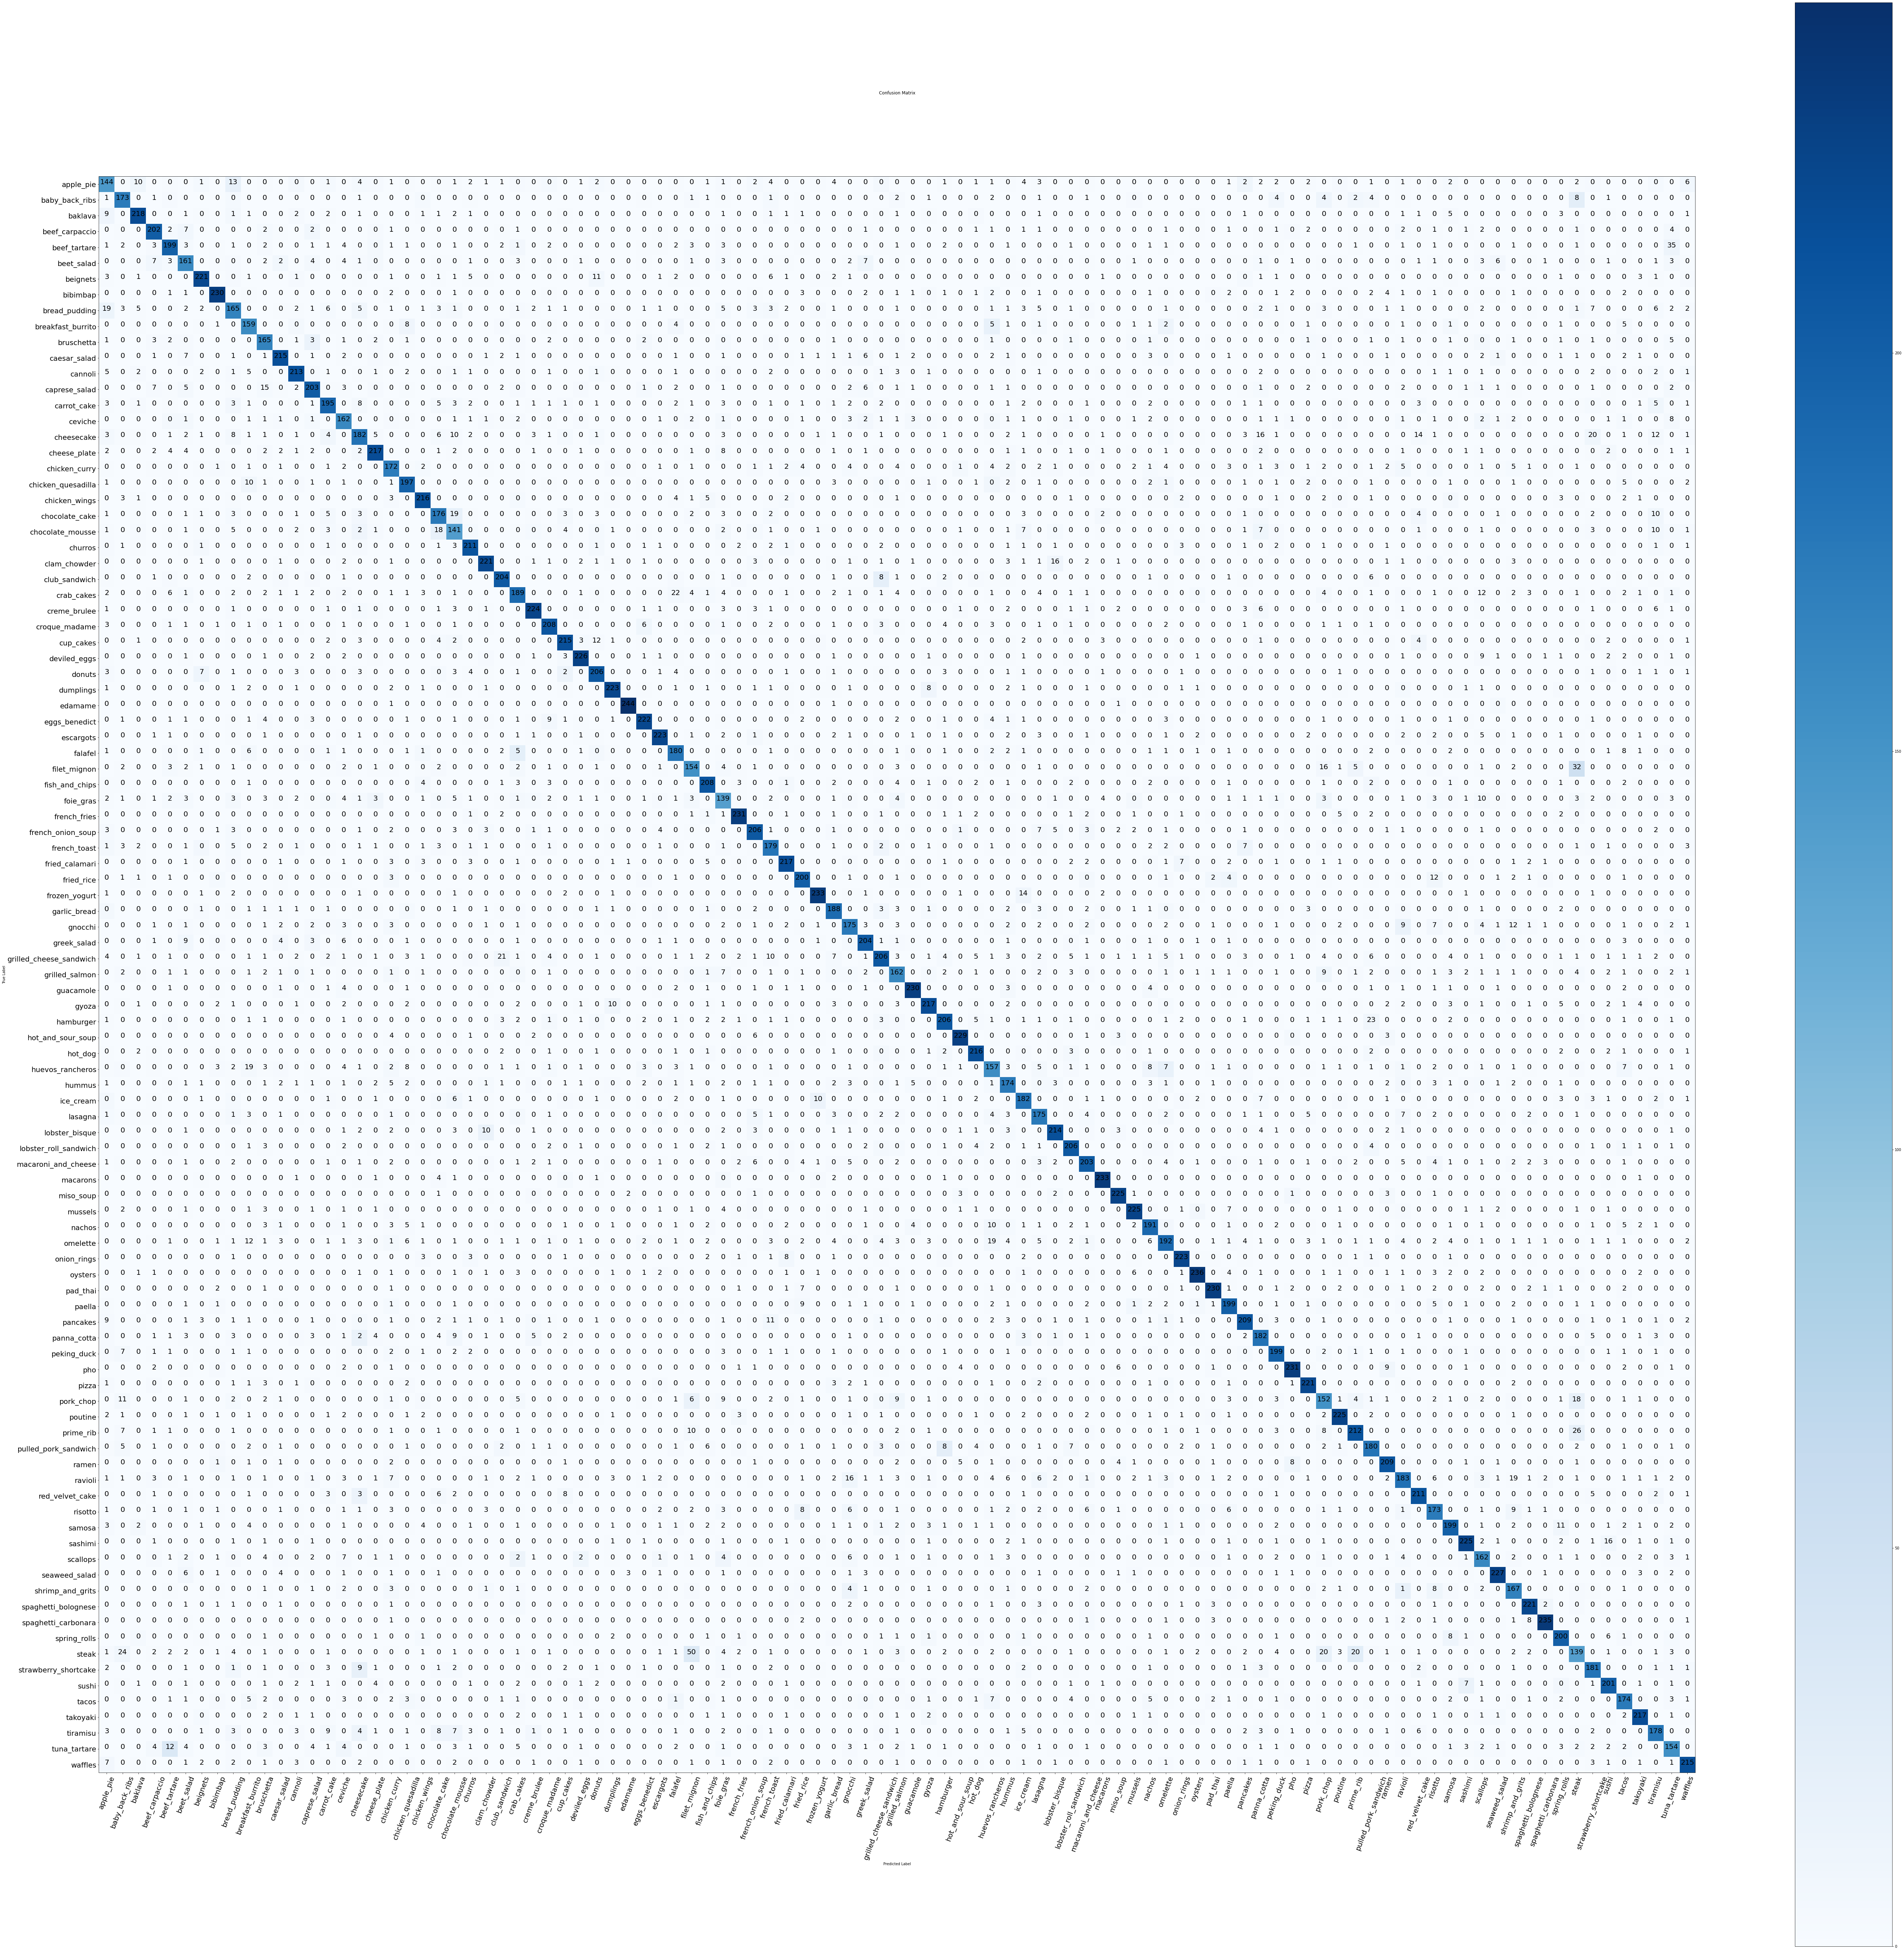

In [ ]:
plot_confusion_matrix(y_true = y_labels, 
                      y_pred = pred_classes, 
                      classes = class_names, 
                      figsize = (100,100), 
                      text_size = 20, 
                      savefig = True)

### .3. Find your model's most wrong predictions 

Find model's most wrong predictions means those with the highest prediction probability but the wrong prediction.

Seeing above evaluation results of `classification_report` and `confusion_matrix`, for some images model is very confident but predicted wrong.

So we have to identify those and plot some.

We will write some code to collect all the predictions where the model has output a high prediction probability for an image (e.g 0.95+) but gotten wrong prediction.

Some steps that we will go through,

1. Get all the image tensors from the test_data
2. Create a pandas Dataframe of the image tensors, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our Dataframe to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_prob": pred_probs.max(axis=1),
                        "y_true_classname":[class_names[i] for i in y_labels],
                        "y_pred_classname":[class_names[i] for i in pred_classes]})

pred_df.head()

,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname
0,29,29,0.999550,cup_cakes,cup_cakes
1,81,81,0.999231,ramen,ramen
2,91,91,0.999990,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.999476,hamburger,hamburger
4,97,97,0.998613,takoyaki,takoyaki


In [ ]:
# 3. Find all the wrong prediction using the dataframe
pred_df['pred_correct'] = pred_df['y_true']==pred_df['y_pred']
pred_df.head()

,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.999550,cup_cakes,cup_cakes,True
1,81,81,0.999231,ramen,ramen,True
2,91,91,0.999990,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.999476,hamburger,hamburger,True
4,97,97,0.998613,takoyaki,takoyaki,True


In [ ]:
# 4. Sort the dataframe by pred_prob descending which have pred_correct = False
top_100_wrong = pred_df[pred_df['pred_correct']==False].sort_values(by='pred_prob', ascending=False)
top_100_wrong.head()

,y_true,y_pred,pred_prob,y_true_classname,y_pred_classname,pred_correct
15437,56,66,1.000000,huevos_rancheros,nachos,False
9735,87,30,1.000000,scallops,deviled_eggs,False
13884,46,10,1.000000,garlic_bread,bruschetta,False
16129,65,69,0.999999,mussels,oysters,False
3182,21,83,0.999999,chocolate_cake,red_velvet_cake,False
